In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from itertools import combinations
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, f1_score, recall_score
from scipy.cluster.hierarchy import fcluster, dendrogram
from scipy import stats
import matplotlib.pyplot as plt

# Load data

In [2]:
data = pd.read_excel('data.xlsx', engine='openpyxl')

## Feature selection
The following features were selected by expert domain knowledge

In [3]:
core_set = [
    'Nachschluck_any2_ohneBrot',
    'Residue_Sinus_Y2',
    'Trigger_spaet',
    'Komplex_dich_A',
    'SehrKomplex_dich_A',
    'Leaking_any_liquids',
    'Oral_Phase_Mehrere_dich',
    'Trigger_kaudal_any_neu',
    'Swallow_Reflex',
    'Whiteout_dich',
    'Spontanschluck',
]

additional_cov = [
    'Alter_dich',
    'Barthel_dich',
]

combined_set = core_set + additional_cov

## Variables of Interest
The following variables are of interest when comparing clusters

In [4]:
variables_of_interest = {
    'MoCA_extrapoliert': 'ordinal',
    'BarthelIndexbeiAufnahme': 'ordinal',
    'FOIS_Vor': 'ordinal',
    'FOIS_Nach': 'ordinal',
    'Schweregrad_cat': 'ordinal',
    'PAS_Gesamt': 'ordinal',
    'Schweregrad_Dysphagie': 'ordinal',
    ### Core Set
    'Nachschluck_any2_ohneBrot': 'binary',
    'Residue_Sinus_Y2': 'binary',
    'Trigger_spaet': 'binary',
    'Komplex_dich_A': 'binary',
    'SehrKomplex_dich_A': 'binary',
    'Leaking_any_liquids': 'binary',
    'Oral_Phase_Mehrere_dich': 'binary',
    'Trigger_kaudal_any_neu': 'binary',
    'Swallow_Reflex': 'binary',
    'Whiteout_dich': 'binary',
    'Spontanschluck': 'binary',
}

## Preprocess data

In [5]:
data[combined_set].isna().sum()

Nachschluck_any2_ohneBrot    0
Residue_Sinus_Y2             0
Trigger_spaet                0
Komplex_dich_A               1
SehrKomplex_dich_A           0
Leaking_any_liquids          0
Oral_Phase_Mehrere_dich      0
Trigger_kaudal_any_neu       1
Swallow_Reflex               0
Whiteout_dich                0
Spontanschluck               2
Alter_dich                   0
Barthel_dich                 0
dtype: int64

Only very few missing data, which will be imputed using the mode:

In [6]:
imputer = SimpleImputer(strategy='most_frequent')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns, index=data.index)
data['Group'] = data['Group'] -1
y = data['Group']

# Analysis

## Functions
Each step of the analysis is a separated function to be repeated with and without covariates

### Clustering

In [7]:
def evaluate_feature_combinations(data, y, feature_combinations):
    """
    Evaluate Agglomerative Clustering performance over multiple feature subsets.

    Parameters
    ----------
    data : pandas.DataFrame
        Dataset containing all features.
    y : array-like
        Ground-truth binary labels (0/1).
    feature_combinations : iterable
        Iterable of feature sets (e.g., list of tuples of column names).

    Returns
    -------
    results_df_sorted : pandas.DataFrame
        Metrics for each feature set, sorted by ARI (descending).
    """

    results = []

    for feature_set in feature_combinations:
        features = list(feature_set)
        X = data[features]

        # Fit clustering
        cluster = AgglomerativeClustering(
            n_clusters=2, metric='euclidean', compute_distances=True
        ).fit(X)

        predicted_labels = cluster.labels_

        # Compute ARI
        ari = adjusted_rand_score(y, predicted_labels)

        # Align cluster labels to the ground truth orientation
        matches_normal = np.sum(y == predicted_labels)
        matches_flipped = np.sum(y == (1 - predicted_labels))

        if matches_flipped > matches_normal:
            predicted_labels = 1 - predicted_labels

        # Compute metrics after alignment
        sensitivity = recall_score(y, predicted_labels, pos_label=1)
        specificity = recall_score(y, predicted_labels, pos_label=0)
        f1 = f1_score(y, predicted_labels)

        results.append({
            'Feature_Set': feature_set,
            'ARI': ari,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'F1_Score': f1
        })

    results_df = pd.DataFrame(results)
    results_df_sorted = results_df.sort_values(by='ARI', ascending=False)
    return results_df_sorted

### Dendrogram

In [8]:
def plot_dendrogram(
    model, data, group_col="Group"
):
    """
    Reconstruct a linkage matrix from an AgglomerativeClustering model, compute
    cluster assignments, summarize per-cluster statistics, and plot a dendrogram.

    Parameters
    ----------
    model : sklearn.cluster.AgglomerativeClustering
        A fitted AgglomerativeClustering model with `children_` and `distances_`
        attributes (requires `compute_distances=True`).

    data : pandas.DataFrame
        The dataset used to fit the model. Must contain the column specified by
        `group_col`.

    group_col : str, default="Group"
        Column in `data` whose cluster-wise mean is computed.

    Returns
    -------
    labels : np.ndarray
        The cluster labels assigned to each sample.

    cluster_stats : dict
        Dictionary containing the mean `group_col` value and size for each cluster.

    fig : matplotlib.figure.Figure
        The matplotlib figure object for the dendrogram.
    """

    # Reconstruct linkage matrix
    n = len(model.labels_)
    Z = np.column_stack([
        model.children_,
        model.distances_,
        np.arange(2, n + 1)
    ])

    color_threshold = 0.7 * Z[:, 2].max()

    # Cluster assignment
    n_clusters = (Z[:, 2] > color_threshold).sum() + 1
    labels = fcluster(Z, t=n_clusters, criterion='maxclust') - 1

    # Cluster stats
    cluster_stats = {
        f"Cluster {i+1}": {
            "mean": data.loc[labels == i, group_col].mean(),
            "size": (labels == i).sum()
        }
        for i in range(n_clusters)
    }

    # Plot dendrogram
    fig = plt.figure(figsize=(10, 6))
    dendrogram(Z, truncate_mode="level", p=4, color_threshold=color_threshold)

    plt.legend(
        [f"{k} (n={v['size']}): {100*v['mean']:.0f}%" for k, v in cluster_stats.items()],
        fontsize=9, loc='upper right',
        title='Dementia rate                 ',
        frameon=True
    )

    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)

    plt.ylabel("Linkage distance (Ward’s method, a. u.)", labelpad=10, fontsize=11)
    plt.tight_layout()

    return labels, fig

### Statistical Analysis

In [9]:
def statistical_analysis(data, labels, variables_of_interest):
    """
    Perform descriptive and inferential statistics for each variable across clusters.

    This function computes summary statistics separately for each cluster and runs the
    appropriate statistical test depending on the variable type:

    - **Binary variables:**  
      Reports count and percentage of 1's within each cluster, followed by a global
      chi-square test across clusters.

    - **Ordinal variables:**  
      Reports median and IQR (Q1–Q3) within each cluster, followed by a global
      Kruskal–Wallis test across clusters.

    P-values are formatted to four decimal places, with values < 0.0001 displayed as
    "< 0.0001". Variables missing from the dataset are reported as NA.

    Parameters
    ----------
    data : pandas.DataFrame
        The dataset containing variables to be analyzed. Rows correspond to samples,
        and columns correspond to variables.

    labels : array-like
        Cluster labels for each sample. Must contain at least two unique clusters.

    variables_of_interest : dict
        A dictionary mapping variable names to their type:
        - `"binary"` for 0/1 or Boolean variables.
        - `"ordinal"` for ordered numeric variables suitable for nonparametric tests.

    Returns
    -------
    pandas.DataFrame
        A table where each row corresponds to a variable and columns show:
        - Cluster-specific descriptive statistics.
        - The p-value for the global test across clusters.

        Columns are structured as:
        `[Cluster 1 (n=...), Cluster 2 (n=...), ..., "p-value"]`.
    """
    
    clusters = sorted(pd.Series(labels).unique())
    if len(clusters) < 2:
        raise ValueError(f"Expected at least 2 clusters, found {len(clusters)}.")

    # Prepare columns
    cluster_cols = [f"Cluster {i+1} (n={sum(labels==c)})" for i, c in enumerate(clusters)]
    result_cols = cluster_cols + ["p-value"]

    results_df = pd.DataFrame(columns=result_cols)

    # Subset data per cluster
    groups = {c: data.loc[labels == c] for c in clusters}

    # Iterate over variables
    for var, vtype in variables_of_interest.items():
        if var not in data.columns:
            results_df.loc[var] = [np.nan] * len(result_cols)
            continue

        stats_per_cluster = []
        p_value = np.nan

        # ----- Binary variable -----
        if vtype == "binary":
            try:
                for c in clusters:
                    vals = groups[c][var].dropna()
                    total = len(vals)
                    if total == 0:
                        desc = "NA"
                    else:
                        count_1 = int(vals.sum())
                        perc = int(round((count_1 / total) * 100))
                        desc = f"{count_1} ({perc}%)"
                    stats_per_cluster.append(desc)

                # Global chi-square test across clusters
                contingency = pd.crosstab(data[var], labels)
                if contingency.shape[0] > 1 and contingency.shape[1] > 1:
                    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
                    # Check if p-value is less than 0.0001
                    if p_value < 0.0001:
                        p_value = "< 0.0001"
                    else:
                        p_value = f"{p_value:.4f}"  # Format p-value to 4 decimal places
                else:
                    p_value = np.nan
            except Exception:
                stats_per_cluster = [np.nan] * len(clusters)

        # ----- Ordinal variable -----
        elif vtype == "ordinal":
            try:
                for c in clusters:
                    vals = groups[c][var].dropna()
                    if len(vals) == 0:
                        desc = "NA"
                    else:
                        med = int(round(vals.median()))
                        q1 = int(round(vals.quantile(0.25)))
                        q3 = int(round(vals.quantile(0.75)))
                        desc = f"{med} (IQR: {q1}-{q3})"
                    stats_per_cluster.append(desc)

                # Global Kruskal–Wallis test
                valid_groups = [groups[c][var].dropna() for c in clusters if len(groups[c][var].dropna()) > 0]
                if len(valid_groups) >= 2:
                    p_value = stats.kruskal(*valid_groups).pvalue
                    # Check if p-value is less than 0.0001
                    if p_value < 0.0001:
                        p_value = "< 0.0001"
                    else:
                        p_value = f"{p_value:.4f}"  # Format p-value to 4 decimal places
            except Exception:
                stats_per_cluster = [np.nan] * len(clusters)

        # Store results (convert all values to string with f-string formatting)
        results_df.loc[var] = [str(stat) for stat in stats_per_cluster] + [str(p_value)]

    return results_df


## Core set
Analyzes only swallowing-related parameters, no covarites.

### Get combinations

In [10]:
feature_combinations = [
    combo for r in range(1, len(core_set) + 1) 
    for combo in combinations(core_set, r)
]

len(feature_combinations)

2047

### Agglomerative clustering

In [11]:
results_df_sorted = evaluate_feature_combinations(data, y, feature_combinations)
results_df_sorted.head(5)

,Feature_Set,ARI,Sensitivity,Specificity,F1_Score
638,"(Nachschluck_any2_ohneBrot, Residue_Sinus_Y2, ...",0.246946,0.846939,0.600000,0.809756
1514,"(Nachschluck_any2_ohneBrot, Residue_Sinus_Y2, ...",0.225464,0.765306,0.700000,0.785340
717,"(Nachschluck_any2_ohneBrot, Komplex_dich_A, Le...",0.212266,0.785714,0.650000,0.785714
601,"(Nachschluck_any2_ohneBrot, Residue_Sinus_Y2, ...",0.212266,0.785714,0.650000,0.785714
672,"(Nachschluck_any2_ohneBrot, Trigger_spaet, Seh...",0.211738,0.795918,0.633333,0.787879


### Fit best model

In [12]:
best_features = results_df_sorted.reset_index().loc[0, 'Feature_Set']
print('Best features:')
for feature in best_features:
    print("-",feature)
X = data[list(best_features)]
best_model = AgglomerativeClustering(n_clusters=2, metric='euclidean', compute_distances=True).fit(X)

Best features:
- Nachschluck_any2_ohneBrot
- Residue_Sinus_Y2
- Oral_Phase_Mehrere_dich
- Swallow_Reflex
- Whiteout_dich


### Dendogram

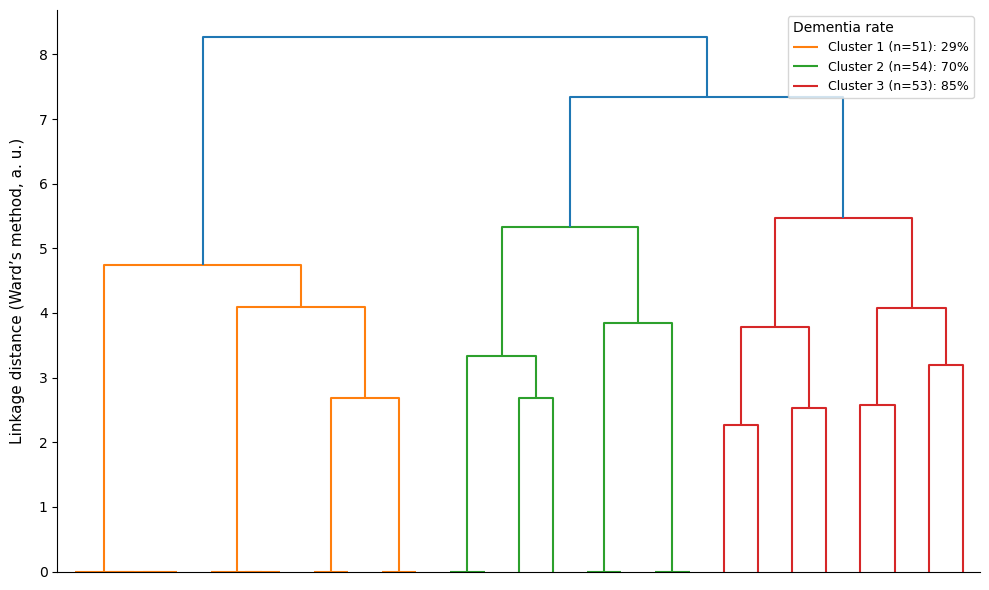

In [13]:
labels, fig = plot_dendrogram(best_model, data)
plt.savefig('./core_set.png', bbox_inches='tight', dpi=300)

### Statistics

In [14]:
results_df = statistical_analysis(data, labels, variables_of_interest)
results_df

,Cluster 1 (n=51),Cluster 2 (n=54),Cluster 3 (n=53),p-value
MoCA_extrapoliert,20 (IQR: 16-23),16 (IQR: 14-19),16 (IQR: 12-18),< 0.0001
BarthelIndexbeiAufnahme,55 (IQR: 45-65),45 (IQR: 40-50),50 (IQR: 45-55),0.0192
FOIS_Vor,7 (IQR: 7-7),7 (IQR: 6-7),7 (IQR: 7-7),0.0434
FOIS_Nach,7 (IQR: 6-7),6 (IQR: 6-7),6 (IQR: 6-7),0.0003
Schweregrad_cat,1 (IQR: 1-1),1 (IQR: 1-1),1 (IQR: 1-1),0.8271
PAS_Gesamt,1 (IQR: 1-1),1 (IQR: 1-3),1 (IQR: 1-2),0.0939
Schweregrad_Dysphagie,1 (IQR: 1-1),2 (IQR: 1-2),1 (IQR: 1-2),0.0071
Nachschluck_any2_ohneBrot,0 (0%),54 (100%),31 (58%),< 0.0001
Residue_Sinus_Y2,15 (29%),30 (56%),34 (64%),0.0011
Trigger_spaet,15 (29%),22 (41%),35 (66%),0.0006


## All Features
Analyzes all variables, including covariates.

### Get combinations

In [15]:
feature_combinations = [
    combo for r in range(1, len(combined_set) + 1) 
    for combo in combinations(combined_set, r)
]

len(feature_combinations)

8191

### Agglomerative clustering

In [16]:
results_df_sorted = evaluate_feature_combinations(data, y, feature_combinations)
results_df_sorted.head(5)

,Feature_Set,ARI,Sensitivity,Specificity,F1_Score
1227,"(Nachschluck_any2_ohneBrot, Residue_Sinus_Y2, ...",0.246946,0.846939,0.600000,0.809756
1565,"(Nachschluck_any2_ohneBrot, Oral_Phase_Mehrere...",0.246946,0.846939,0.600000,0.809756
1496,"(Nachschluck_any2_ohneBrot, SehrKomplex_dich_A...",0.231275,0.877551,0.533333,0.811321
4150,"(Nachschluck_any2_ohneBrot, Residue_Sinus_Y2, ...",0.225464,0.765306,0.700000,0.785340
1226,"(Nachschluck_any2_ohneBrot, Residue_Sinus_Y2, ...",0.225075,0.775510,0.683333,0.787565


### Fit best model

In [17]:
best_features = results_df_sorted.reset_index().loc[0, 'Feature_Set']
print('Best features:')
for feature in best_features:
    print("-",feature)
X = data[list(best_features)]
best_model = AgglomerativeClustering(n_clusters=2, metric='euclidean', compute_distances=True).fit(X)

Best features:
- Nachschluck_any2_ohneBrot
- Residue_Sinus_Y2
- Oral_Phase_Mehrere_dich
- Swallow_Reflex
- Whiteout_dich


### Dendogram

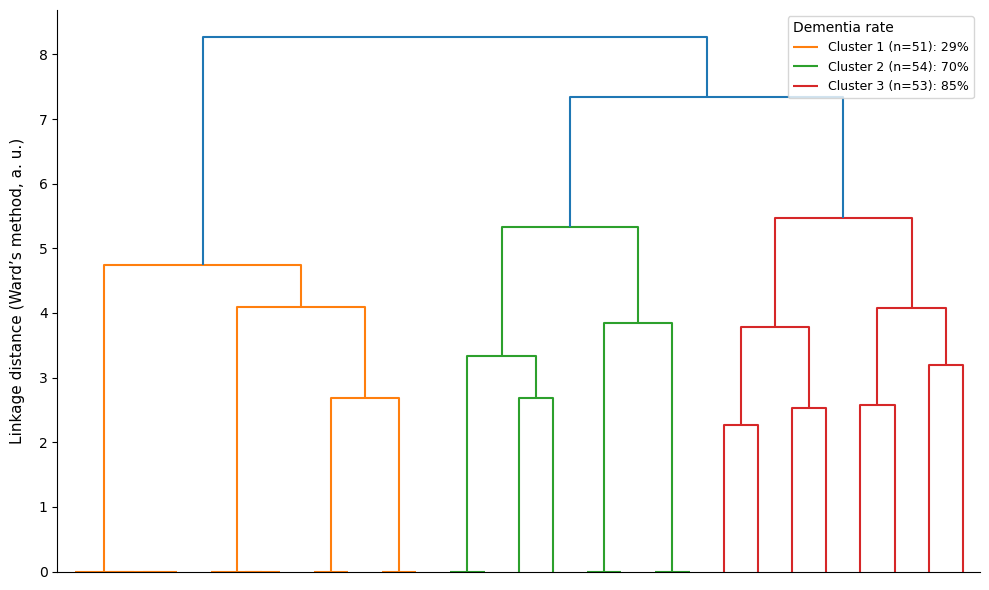

In [18]:
labels, fig = plot_dendrogram(best_model, data)
plt.savefig('./all.png', bbox_inches='tight', dpi=300)

### Statistics

In [19]:
results_df = statistical_analysis(data, labels, variables_of_interest)
results_df

,Cluster 1 (n=51),Cluster 2 (n=54),Cluster 3 (n=53),p-value
MoCA_extrapoliert,20 (IQR: 16-23),16 (IQR: 14-19),16 (IQR: 12-18),< 0.0001
BarthelIndexbeiAufnahme,55 (IQR: 45-65),45 (IQR: 40-50),50 (IQR: 45-55),0.0192
FOIS_Vor,7 (IQR: 7-7),7 (IQR: 6-7),7 (IQR: 7-7),0.0434
FOIS_Nach,7 (IQR: 6-7),6 (IQR: 6-7),6 (IQR: 6-7),0.0003
Schweregrad_cat,1 (IQR: 1-1),1 (IQR: 1-1),1 (IQR: 1-1),0.8271
PAS_Gesamt,1 (IQR: 1-1),1 (IQR: 1-3),1 (IQR: 1-2),0.0939
Schweregrad_Dysphagie,1 (IQR: 1-1),2 (IQR: 1-2),1 (IQR: 1-2),0.0071
Nachschluck_any2_ohneBrot,0 (0%),54 (100%),31 (58%),< 0.0001
Residue_Sinus_Y2,15 (29%),30 (56%),34 (64%),0.0011
Trigger_spaet,15 (29%),22 (41%),35 (66%),0.0006


## Find Whiteout Interactions
Whiteout was not statistically significant in the univariate analysis. \
Inclusion in the optimal feature set may have been due to interaction effects.

In [20]:
interactions = [
    'Nachschluck_any2_ohneBrot',
    'Residue_Sinus_Y2', 
    'Oral_Phase_Mehrere_dich',
    'Swallow_Reflex'
]

# Create interaction terms as categorical variables
for var in interactions:
    interaction_name = f"Whiteout_{var}_interaction"
    data[interaction_name] = data['Whiteout_dich'].astype(str) + '_' + data[var].astype(str)

results = []

# Perform Chi-squared tests for each interaction term
for var in interactions:
    interaction_name = f"Whiteout_{var}_interaction"
    
    # Global Chi-squared test (all categories combined)
    contingency_table = pd.crosstab(data[interaction_name], data['Group'])
    chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)
    p_val_str = f"< 0.0001" if p_val < 0.0001 else f"{p_val:.4f}"
    
    results.append({
        'interaction': interaction_name,
        'category': 'Global (All categories)',
        'p_value': p_val_str
    })
    
    # Chi-squared tests for each category vs. the rest (One-vs-Rest)
    categories = data[interaction_name].unique()
    for category in categories:
        data['Category_vs_Rest'] = (data[interaction_name] == category).astype(int)
        contingency_table = pd.crosstab(data['Category_vs_Rest'], data['Group'])
        chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)
        p_val_str = f"< 0.0001" if p_val < 0.0001 else f"{p_val:.4f}"
        
        results.append({
            'interaction': interaction_name,
            'category': category,
            'p_value': p_val_str
        })

# Show results
results_df = pd.DataFrame(results)
results_df

,interaction,category,p_value
0,Whiteout_Nachschluck_any2_ohneBrot_interaction,Global (All categories),0.0004
1,Whiteout_Nachschluck_any2_ohneBrot_interaction,0.0_0.0,0.0067
2,Whiteout_Nachschluck_any2_ohneBrot_interaction,0.0_1.0,0.0018
3,Whiteout_Nachschluck_any2_ohneBrot_interaction,1.0_1.0,0.3106
4,Whiteout_Nachschluck_any2_ohneBrot_interaction,1.0_0.0,0.0966
5,Whiteout_Residue_Sinus_Y2_interaction,Global (All categories),0.0543
6,Whiteout_Residue_Sinus_Y2_interaction,0.0_0.0,0.1656
7,Whiteout_Residue_Sinus_Y2_interaction,0.0_1.0,0.0435
8,Whiteout_Residue_Sinus_Y2_interaction,1.0_1.0,0.5241
9,Whiteout_Residue_Sinus_Y2_interaction,1.0_0.0,0.2053
